# Importing all the necessary libraries

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import random
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# Loading the data

In [5]:
amazon_reviews_dataset = pd.read_csv('reviews.csv', quotechar='"')
print(amazon_reviews_dataset.head())

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

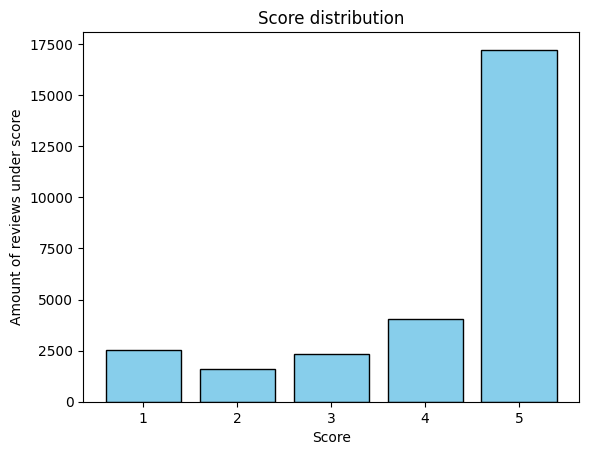

In [23]:
# Count the occurrences of each score and ensure the order is from 1 to 5
counts = amazon_reviews_dataset['Score'].value_counts().sort_index()

# Create a bar plot
plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')

plt.xlabel('Score')
plt.ylabel('Amount of reviews under score')
plt.title('Score distribution')

plt.show()


# Pre-processing the data

In [11]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Function to preprocess text by converting to lowercase, tokenizing,
    removing stopwords and punctuations, and lemmatizing.
    """
    # Convert text to lowercase
    text = str(text).lower()
    # Tokenize text
    tokens = word_tokenize(text)
    # Load stopwords only once to improve performance
    stop_words = set(stopwords.words('english'))
    # Remove stopwords and punctuations
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    # Lemmatize words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

def map_label(score):
    """
    Maps a numerical score to a category label.
    """
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

# Apply preprocessing to the dataset
amazon_reviews_dataset['processed_text'] = amazon_reviews_dataset['Text'].apply(preprocess_text)

# Map scores to categories
amazon_reviews_dataset['true_category'] = amazon_reviews_dataset['Score'].apply(map_label)


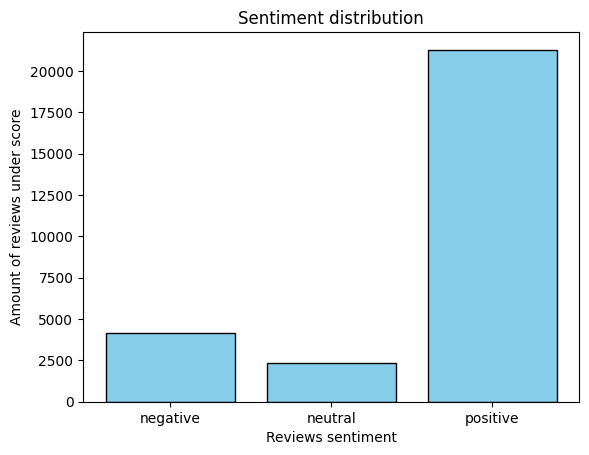

In [18]:
# Count the occurrences of each category
category_counts = amazon_reviews_dataset['true_category'].value_counts()[['negative', 'neutral', 'positive']]

# Create a bar plot
plt.bar(category_counts.index, category_counts.values, color='skyblue', edgecolor='black')

plt.xlabel('Reviews sentiment')
plt.ylabel('Amount of reviews under score')
plt.title('Sentiment distribution')
plt.show()


# Performing sentiment analysis with lexicon-based algorithms

Accuracy for TextBlob: 0.7231358773750599

Classification Report for TextBlob:
              precision    recall  f1-score   support

    negative       0.64      0.21      0.32       924
     neutral       0.13      0.29      0.18       478
    positive       0.86      0.86      0.86      4861

    accuracy                           0.72      6263
   macro avg       0.54      0.45      0.45      6263
weighted avg       0.77      0.72      0.73      6263

Accuracy for VADER: 0.7900367236148811

Classification Report for VADER:
              precision    recall  f1-score   support

    negative       0.58      0.28      0.38       924
     neutral       0.15      0.04      0.07       478
    positive       0.82      0.96      0.89      4861

    accuracy                           0.79      6263
   macro avg       0.52      0.43      0.44      6263
weighted avg       0.73      0.79      0.75      6263



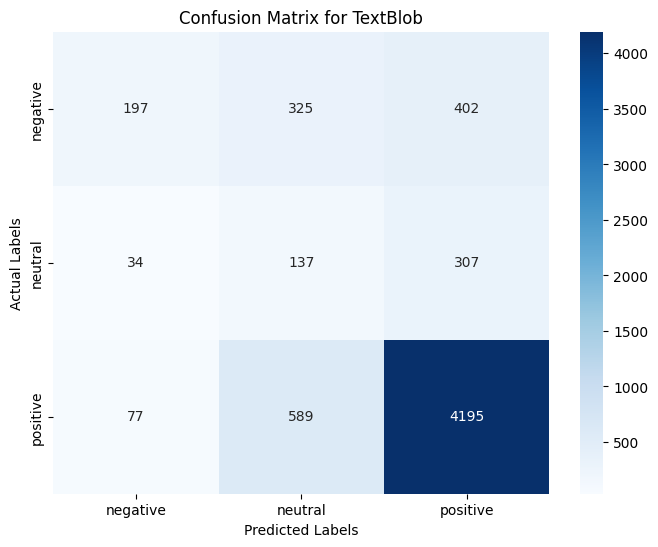

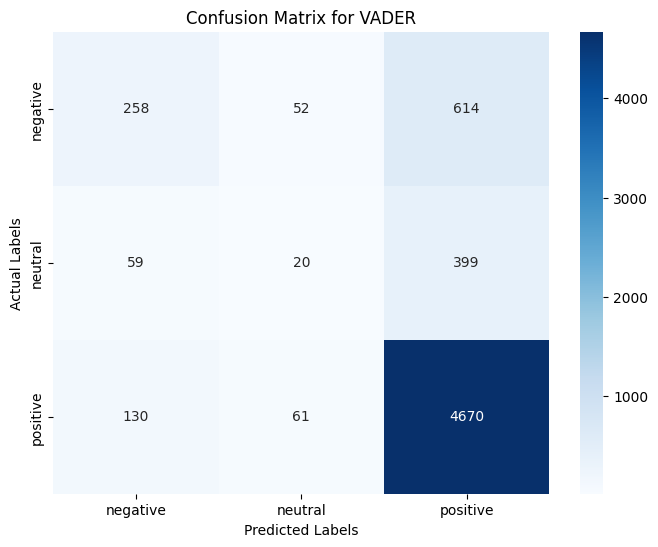

In [ ]:
# Function to return the polarity score using TextBlob
def get_textblob_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to return the compound score using VADER
def get_vader_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Function to apply sentiment analysis to a DataFrame
def apply_sentiment_analysis(df):
    df['TextBlob_Sentiment'] = df['processed_text'].apply(get_textblob_sentiment)
    df['VADER_Sentiment'] = df['processed_text'].apply(get_vader_sentiment)
    return df

# Classify TextBlob scores into categories
def classify_textblob(score):
    if score <= -0.1:
        return 'negative'
    elif score <= 0.1:
        return 'neutral'
    else:
        return 'positive'

# Classify VADER scores into categories
def classify_vader(score):
    if score <= -0.05:
        return 'negative'
    elif score <= 0.05:
        return 'neutral'
    else:
        return 'positive'

# Apply sentiment analysis and categorization
amazon_reviews_sentiment = apply_sentiment_analysis(amazon_reviews_dataset)
amazon_reviews_sentiment['TextBlob_category'] = amazon_reviews_sentiment['TextBlob_Sentiment'].apply(classify_textblob)
amazon_reviews_sentiment['VADER_category'] = amazon_reviews_sentiment['VADER_Sentiment'].apply(classify_vader)

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Evaluation metrics
def calculate_accuracy_and_report(df, true_col, pred_col, model_name):
    accuracy = accuracy_score(df[true_col], df[pred_col])
    report = classification_report(df[true_col], df[pred_col], target_names=['negative', 'neutral', 'positive'])
    print(f"Accuracy for {model_name}: {accuracy}")
    print(f"\nClassification Report for {model_name}:\n{report}")

calculate_accuracy_and_report(amazon_reviews_sentiment, 'true_category', 'TextBlob_category', 'TextBlob')
calculate_accuracy_and_report(amazon_reviews_sentiment, 'true_category', 'VADER_category', 'VADER')

# Function to plot confusion matrix
def plot_confusion_matrix(df, true_col, pred_col, model_name):
    cm = confusion_matrix(df[true_col], df[pred_col])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

# Plotting confusion matrices
plot_confusion_matrix(amazon_reviews_sentiment, 'true_category', 'TextBlob_category', 'TextBlob')
plot_confusion_matrix(amazon_reviews_sentiment, 'true_category', 'VADER_category', 'VADER')

# Performing sentiment analysis with machine learning algorithms

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

    negative       0.67      0.60      0.63       245
     neutral       0.38      0.28      0.32       144
    positive       0.88      0.92      0.90      1249

    accuracy                           0.82      1638
   macro avg       0.64      0.60      0.62      1638
weighted avg       0.80      0.82      0.81      1638

Confusion Matrix for Naive Bayes:


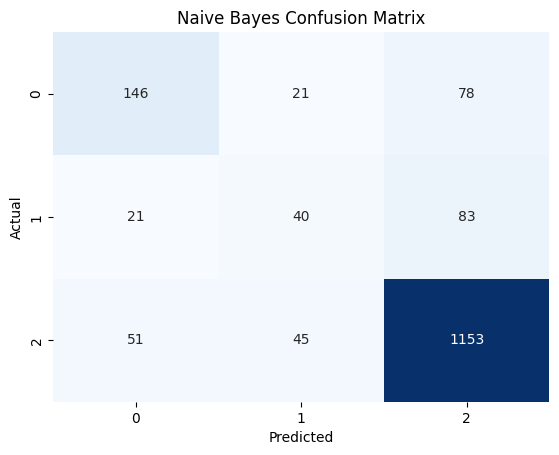

Classification Report for Random Forest:
              precision    recall  f1-score   support

    negative       0.79      0.17      0.28       245
     neutral       0.50      0.01      0.01       144
    positive       0.79      1.00      0.88      1249

    accuracy                           0.79      1638
   macro avg       0.69      0.39      0.39      1638
weighted avg       0.76      0.79      0.71      1638

Confusion Matrix for Random Forest:


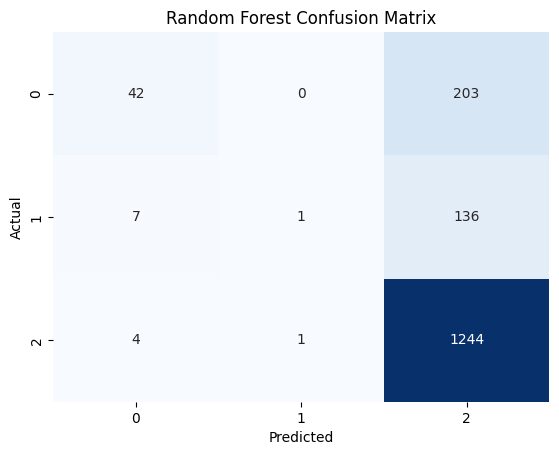

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    amazon_reviews_dataset['processed_text'],
    amazon_reviews_dataset['true_category'],
    test_size=0.2,
    random_state=42
)

# Vectorize the text data
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Define parameter grids for GridSearchCV
nb_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [10, 50, 100, None]}

# Initialize GridSearchCV for Naive Bayes and Random Forest with 'f1_weighted' scoring
nb_grid = GridSearchCV(MultinomialNB(), nb_params, cv=5, scoring='f1_weighted')
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='f1_weighted')

# Fit models
nb_grid.fit(X_train_vect, y_train)
rf_grid.fit(X_train_vect, y_train)

# Predict using the best models
nb_predictions = nb_grid.best_estimator_.predict(X_test_vect)
rf_predictions = rf_grid.best_estimator_.predict(X_test_vect)

# Evaluation metrics
def calculate_accuracy_and_report(y_true, y_pred, model_name):
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))
    print(f"Confusion Matrix for {model_name}:")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Generate reports for both models
calculate_accuracy_and_report(y_test, nb_predictions, 'Naive Bayes')
calculate_accuracy_and_report(y_test, rf_predictions, 'Random Forest')

In [ ]:
#display the best parameters
print(nb_grid.best_estimator_)
print(rf_grid.best_estimator_)

MultinomialNB(alpha=0.1)
RandomForestClassifier(n_estimators=50, random_state=42)
